# Term Project (Group 34)

---

**Anis, Emilia, Eric, Peter**

## Introduction

### Background

The Pacific Laboratory for Artificial Intelligence is a research group within the department of computer science at University of British Columbia, led by Frank Wood. As part of their work, they have set up a Minecraft server where they aim to collect data about player's actions within the game. To run this project, they need to know how to target their recruitment efforts and make sure they have enough resources. This report aims to support the research group with a data analysis to help them target their recruitment efforts by investigating what player characteristics and behaviours are most predictive of subscribing to a game-related newspaper, and how these features differ between various player types. More specifically, the following research question will be investigated.

> *Can player's age, experience, gender, and number of hours played predict subscription to a game-related newspaper?*

### Data description

For this analysis, a dataset with information about 196 players using the server, is used. The data is collected within the server, with the player's consent. the dataset has the dimensions 196 x 7 and contains missing values. For each player, the following variables (Figure 1) are recorded.

| Variable name    | Type | Description |
| -------- | ------- | ------- |
| experience  | Character    | The player's experience level (Amateur/ Beginner/ Regular/ Veteran/ Pro)  |
| subscribe | Logical     | Does the player subscribe to a game-related newspaper (TRUE/ FALSE) |
| hashedEmail    | Character    | Unique hash-code representing the player's email |
| played_hours    | Double    | Total number of hours played |
| name    | Character    | Player's name |
| gender    | Character    | Player's gender (Female/ Male) |
| Age    | Double    | Player's age |
<center>
Figure 1.
</center>

## Methods & Results

In the following section, after cleaning and exploring the datatset, we will use K-Nearest Neighbors (KNN) classification to predict whether a player subscribes to a newsletter based on their age, played hours, gender and experience level. We have chosen KNN as the response variable (subscribe) is binary making it suitable for a classification problem. Moreover, the relationship between the explanatory variables is non-linear which KNN classification handles well unlike linear regression.

#### Load libraries

In [38]:
library(tidyverse)
library(tidymodels)

set.seed(10)

#### Load dataset

In [39]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [40]:
head(players, 10)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


### Wrangling and Cleaning of the Data

With a focus on the variables age, experience, gender, hours played, and the predictor subscribe, we first cleaned and wrangled the data to create a tidy dataset (Figure 2) for analysis. The original dataset was filtered to remove rows with NA values, and only the key variables listed above were retained. Finally, several variables were loaded with incorrect datatypes when reading the CSV, so we reassigned them appropriately. In particular, experience and gender were set as factor variables.

In [41]:
tidy_players <- players |>
                filter(!is.na(Age)) |>
                select(Age, played_hours, experience, gender, subscribe) |>
                mutate(
                     Age = as.integer(Age),
                     played_hours = as.numeric(played_hours),
                     experience = as.factor(experience),
                     gender = as.factor(gender),
                     subscribe = as.logical(subscribe) 
                 )

In [42]:
head(tidy_players, 10)

Age,played_hours,experience,gender,subscribe
<int>,<dbl>,<fct>,<fct>,<lgl>
9,30.3,Pro,Male,TRUE
17,3.8,Veteran,Male,TRUE
17,0.0,Veteran,Male,FALSE
21,0.7,Amateur,Female,TRUE
21,0.1,Regular,Male,TRUE
17,0.0,Amateur,Female,TRUE
19,0.0,Regular,Female,TRUE
21,0.0,Amateur,Male,FALSE
47,0.1,Amateur,Male,TRUE


                  Figure 2.

#### Summary statistics

The numerical variables in the dataset, player's age and number of played hours, can be summarized with the table below (Figure 3).

In [43]:
summary <- summarize(tidy_players, 
         min_played_hours = round(min(played_hours, na.rm = TRUE), 2),
         max_played_hours = round(max(played_hours, na.rm = TRUE), 2),
         mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
         sd_played_hours = round(sd(played_hours, na.rm = TRUE), 2),
         min_age = round(min(Age, na.rm = TRUE), 2),
         max_age = round(max(Age, na.rm = TRUE), 2),
         mean_age = round(mean(Age, na.rm = TRUE), 2),
         sd_age = round(sd(Age, na.rm = TRUE), 2))

summary_table <- tibble(
  variable = c("played_hours", "Age"),
  min  = c(summary$min_played_hours, summary$min_age),
  max  = c(summary$max_played_hours, summary$max_age),
  mean = c(summary$mean_played_hours, summary$mean_age),
  std   = c(summary$sd_played_hours, summary$sd_age)
)

summary_table

variable,min,max,mean,std
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
played_hours,0,223.1,5.90,28.50
Age,9,58.0,21.14,7.39


               Figure 3.

### Exploratory Visualisations

Before conducting the analysis, we first created three visualisations of the dataset to support exploratory data analysis. This allows us to better understand the structure of the data, how we should approach the classification task, and whether any additional tidying of the data are necessary before proceeding.

#### Age vs Played Hours of Plaicraft Players

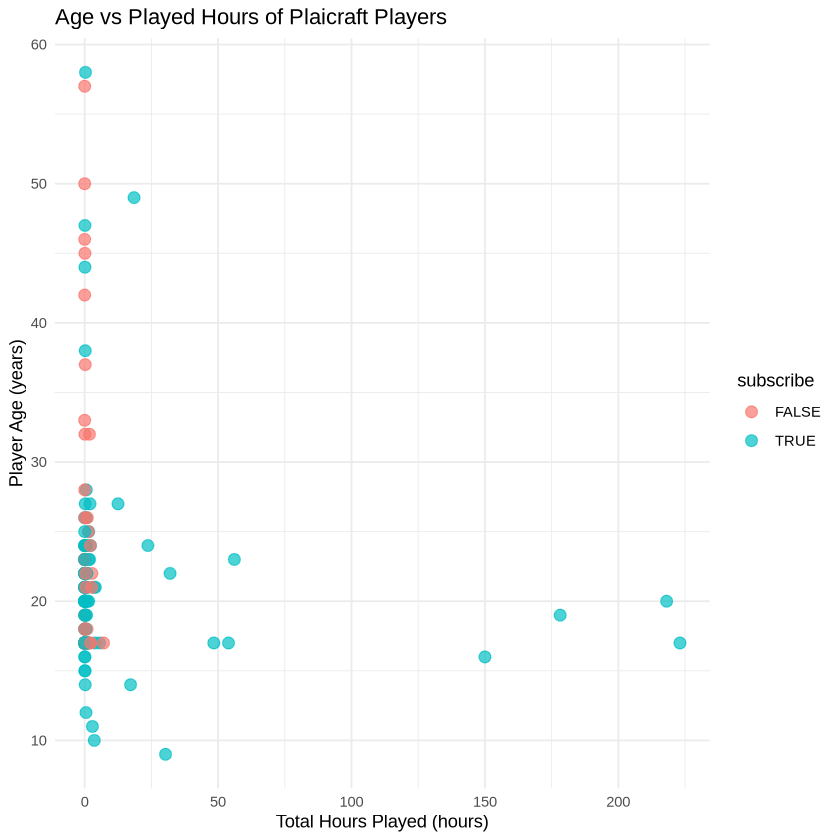

In [44]:
scatter_plot <- tidy_players |>
                ggplot(aes(x = played_hours, y = Age, colour = subscribe)) +
                geom_point(alpha = 0.7, size = 3) +
                labs(
                    title = "Age vs Played Hours of Plaicraft Players",
                    x = "Total Hours Played (hours)",
                    y = "Player Age (years)"
                ) +
                theme_minimal()

scatter_plot

                   Figure 4.

**Figure 4 Insights:**
*  Non-subscribed players never exceed a total playtime of 13 hours.
* Many non-subscribed players cluster near zero total playtime, indicating minimal engagement.
* Some subscribed players have extremely high total playtimes (over 200 hours), which heavily inflates the average playtime for this group.

#### Ratio of Subscribed Players per Each Experience Level

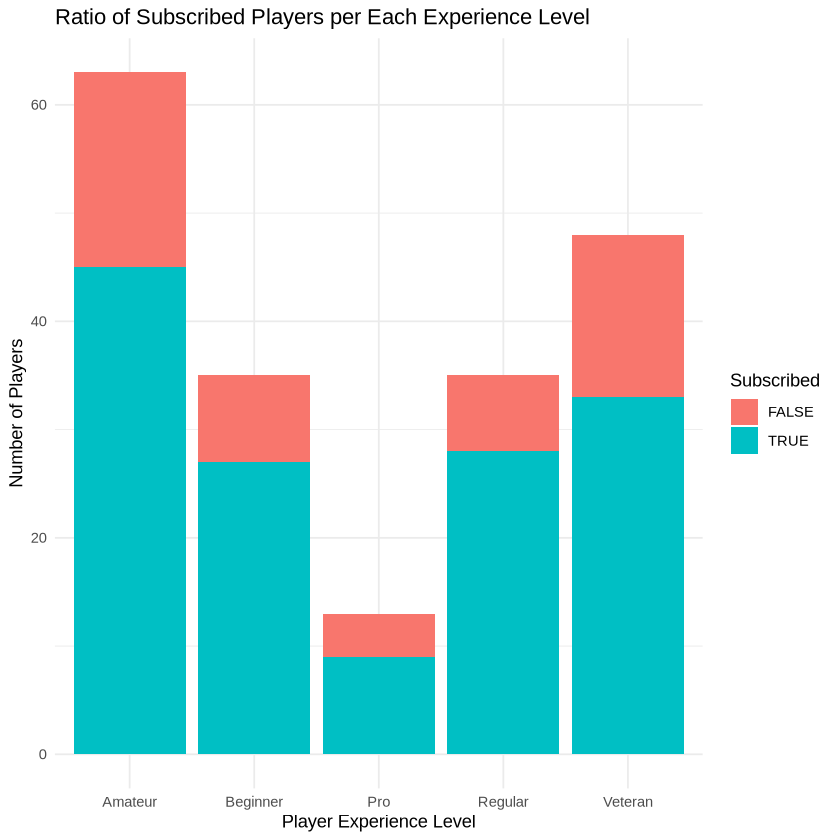

In [45]:
bar_plot_1 <- tidy_players |>
                ggplot(aes(x = experience, fill = subscribe)) +
                geom_bar() +
                labs(
                    title = "Ratio of Subscribed Players per Each Experience Level",
                    x = "Player Experience Level",
                    y = "Number of Players",
                    fill = "Subscribed"
                ) + 
                scale_y_continuous() +
                theme_minimal()

bar_plot_1

                         Figure 5.   

**Figure 5 Insights:**
* Pro players seem to have the highest raio of subscribed players
* Veteran is likely the most experienced level but not the most subscribed ratio
* This suggest the relationship between experience and susbcription may be more complicated than a direct relationship between the two variables

#### Subscription Based on Gender

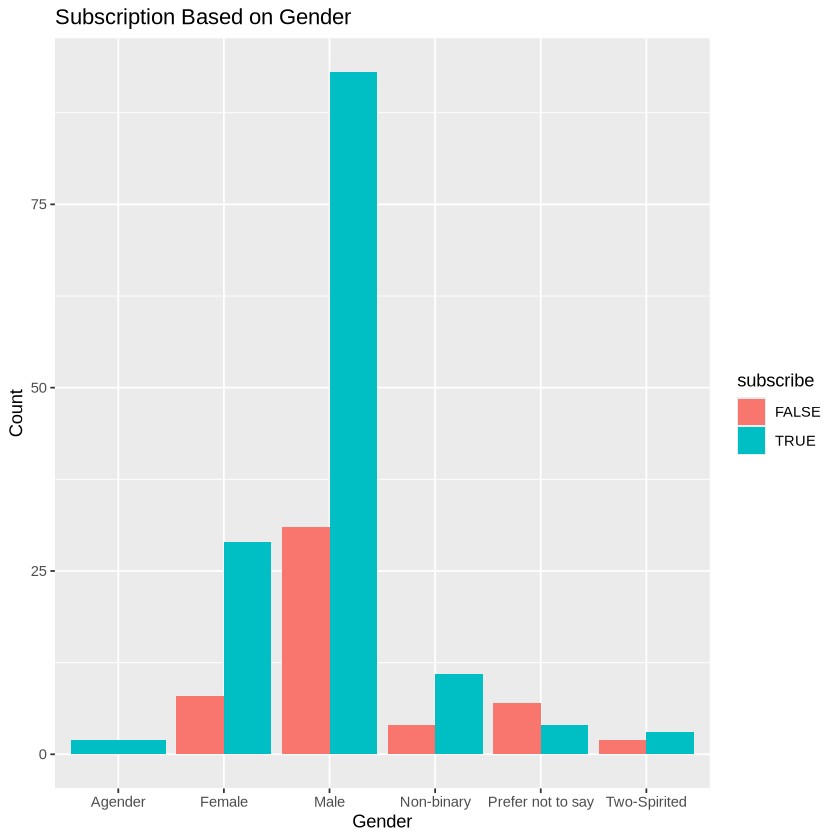

In [46]:
sub_on_gender <- tidy_players |>
                 ggplot(aes(x = gender, fill = subscribe)) +
                 geom_bar(position = "dodge") +
                 labs(title = "Subscription Based on Gender",
                 x = "Gender", y = "Count")

sub_on_gender

                         Figure 6.

**Figure 6 Insights:**

* Male players have the highest subscription count, making them the dominant subscriber group
* Female players subscribe less overall, but their subscribe-to-non-subscribe ratio is similar to males.

**I have added the first part of the methods and results. Please add**
* **performs the data analysis**
* **creates a visualization of the analysis**

**let me know if there are any issues with my work above so I can fix it or if you need help - Anis**

## Discussion

## References